In [77]:
import pandas as pd, numpy as np, os
from scipy.optimize import minimize
from functools import partial
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.ticker import(FixedLocator, FixedFormatter, 
                              StrMethodFormatter, FuncFormatter)

# %matplotlib notebook
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['lines.solid_capstyle'] = 'round'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['figure.figsize'] = [6.5, 4.5]
mpl.rcParams['axes.grid'] = False
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

Let’s suppose an investor considers 5 risky assets. The covariance matrix, and the average returns of these assets are: $k_1$ = 1.90%, $k_2$ = 1.30%, $k_3$ = 1.00%, $k_4$ = 1.52%, and $k_5$ = 1.30%. Let’s also assume $R_f$ = 0.5%.

In [5]:
k = np.r_[0.0190, 0.0130, 0.0100, 0.0152, 0.0130].reshape(-1,1)

In [63]:
rf = 0.005

In [7]:
cov  = [[0.056, 0.017, 0.008, 0.023, 0.007],
        [0.017, 0.031, 0.009, 0.013, 0.004],
        [0.008, 0.009, 0.038, 0.018, 0.002],
        [0.023, 0.013, 0.018, 0.032, 0.006],
        [0.007, 0.004, 0.002, 0.006, 0.090]]

In [8]:
def obj_func(w, k, cov):
    '''The objective function to be minimized'''
    w = w.reshape(-1,1)
    k = k.reshape(-1,1)
    return 1/abs(float(w.T.dot(k)[0]/
                       w.T.dot(cov).dot(w)[0]))

In [9]:
"="*65

'================================================================='

In [12]:
def MarkowitzPortlolio(cov, k, rf=0):
    
    '''
    =================================================================
    
    Parameters
    ----------
    cov : ndarray, shape (n_assets, n_assets)
        The covariance matrix of assets.
    
    k : ndarray, shape (n_assets,)
        The average return of assets.
    
    rf : float, default=0
        Risk-Free rate.
        
    References
    ----------
    .. [1] https://docs.scipy.org/doc/scipy/reference/generated/
           scipy.optimize.minimize.html
           
    Returns
    -------
    props : ndarray, shape (n_assets, 3)
        Row represents the proportions invested in each asset while
        columns represents portfolios as follows:
        
        [1] "MVP"
        [2] "TG0"
        [3] "TGR" : a portfolio on the efficient frontier which is 
        also on the tangent line from the origin.
    
    rets : ndarray, shape (3,)
        Weighted average return of portfolios. 
    
    vars : ndarray, shape (3,)
        Variances of portfolios.
    
    '''
    # Minimum Variance Portfolio (MVP)
    n_assets = len(k)
    ones = np.ones((n_assets,1))
    a0 = np.linalg.inv(cov).dot(ones)
    a1 = np.linalg.inv(ones.T.dot(a0).T)
    MVP = a0.dot(a1).ravel()
    
    # Parameters for optimization
    # https://docs.scipy.org/doc/scipy/reference/generated/
    # scipy.optimize.minimize.html
    con = {'type':'eq', 'fun': lambda w: 1 - sum(w)}
    opt = {"maxiter":1000, "disp":False}
    kwds = {"x0" : MVP, "method": "SLSQP", 
            "constraints":con, "options":opt}
    
    # Tangent Portfolio from origin
    fns = [partial(obj_func, k=k-c, cov=cov) for c in [0,rf]]
    TGs = [minimize(**{**kwds,**{"fun":f}}).x for f in fns]
    props = np.vstack(([MVP] + TGs)).T
    
    # Weighted average returns and Variances
    rets = k.reshape(1,-1).dot(props).ravel()
    vols = props.T.dot(cov).dot(props)[np.identity(3)==1]
    
    return props, rets, vols

In [64]:
props, rets, vols = MarkowitzPortlolio(cov, k, rf)

In [65]:
props

array([[0.07812223, 0.14651433, 0.18450608],
       [0.34383498, 0.30697032, 0.28652139],
       [0.26830746, 0.18548815, 0.13952231],
       [0.15800344, 0.21501813, 0.2466515 ],
       [0.1517319 , 0.14600907, 0.14279871]])

In [28]:
def EfficientFrontier(mvp, tgn, k, cov, n_steps=10, bound=(0,1)):
    
    '''
    =================================================================
    An efficient frontier is a set of investment portfolios that are 
    expected to provide the highest returns at a given level of risk.
    
    Parameters
    ----------
    
    Returns
    -------
    
    '''
    # Risk tolerances and corresponding proportion invested
    coefs = np.linspace(*bound, n_steps)
    props = np.vstack([(1-c)*mvp + c*tgn for c in coefs]).T
    
    # Weighted average returns and Variances
    rets = k.reshape(1,-1).dot(props).ravel()
    vols = props.T.dot(cov).dot(props)[np.identity(n_steps)==1]
    
    return rets, vols

In [ ]:
def gini_plot_base(y_true, y_proba, ax=None, n_ticks=6, colors=None, 
                   plot_kwds=None, fill_kwds=None, tight_layout=True):

    '''

        
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Target array (binary).
        
    y_proba : array-like of shape (n_samples,)
        Probability array.
        
    ax : Matplotlib axis object, default=None
        Predefined Matplotlib axis. If None, ax is created with 
        default figsize.
    
    n_ticks : int, default=6
        Number of ticks to be displayed on x-axis, and y-axis.
        
    colors : list of color-hex, default=None
        Number of color-hex must be greater than or equal to 2. 
        If None, it uses default colors from Matplotlib.
        
    plot_kwds : keywords, default=None
        Keyword arguments to be passed to "ax.plot". If None, it uses 
        default settings.
        
    fill_kwds : keywords, default=None
        Keyword arguments to be passed to "ax.fill_between". If None, 
        it uses default settings.
        
    tight_layout : bool, default=True
        If True, it adjusts the padding between and around subplots 
        i.e. plt.tight_layout().
    
    References
    ----------
    .. [1] ROC curve, https://en.wikipedia.org/wiki/Receiver_operating
           _characteristic
    .. [2] https://towardsdatascience.com/using-the-gini-coefficient-
           to-evaluate-the-performance-of-credit-score-models-
           59fe13ef420
    Returns
    -------
    ax : Matplotlib axis object  
            
    '''
    
    # =============================================================
    if ax is None: ax = plt.subplots(figsize=(6.5, 4))[1] 
    colors = ([ax._get_lines.get_next_color()] * 2 
              if colors is None else colors)
    # -------------------------------------------------------------
    bins = np.percentile(y_proba, np.arange(101))
    bins = np.unique(np.r_[[0,1], bins])
    cfm = np.array([confusion_matrix(y_true, (y_proba>=c)).ravel() 
                    for c in bins])
    fpr = cfm[:,1] / cfm[:,[0,1]].sum(1)
    tpr = cfm[:,3] / cfm[:,[2,3]].sum(1)
    auc  = roc_auc_score(y_true, y_proba)
    gini = 2 * auc - 1
    # =============================================================
    
    # =============================================================
    default = {'color' : colors[0], 'linewidth' : 2.5}
    plot_kwds = (default if plot_kwds is None 
                 else {**default, **plot_kwds})
    # -------------------------------------------------------------
    default = {'alpha':0.2 , 'color':colors[1], 'y1':tpr, 'y2':fpr}
    fill_kwds = (default if fill_kwds is None 
                 else {**default, **fill_kwds})
    # -------------------------------------------------------------
    label = 'ROC ({:,.2%})'.format(auc)
    ax.plot(fpr, tpr, **{**plot_kwds, **{'label' : label}})
    label = 'Gini ({:,.2%})'.format(gini)
    ax.fill_between(fpr, **{**fill_kwds, **{'label' : label}})
    ax.plot([0,1], [0,1], **dict(ls="--", lw=1, color="grey", 
                                 label = 'Random Classifier'))
    # =============================================================

    # Set other attributes.
    # =============================================================
    t = ticker.PercentFormatter(xmax=1)
    ax.xaxis.set_major_formatter(t)
    ax.yaxis.set_major_formatter(t)
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(n_ticks))
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(n_ticks))
    # -------------------------------------------------------------
    ax.set_xlabel('False Positive Rate', fontsize=13)
    ax.set_ylabel('True Positive Rate', fontsize=13)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_facecolor('white')
    ax.patch.set_alpha(0)
    ax.tick_params(axis='both', labelsize=10.5)
    # -------------------------------------------------------------
    args = (ax.transAxes, ax.transAxes)
    transform = transforms.blended_transform_factory(*args)
    ax.text(0, 1.01, "f(x)", fontsize=13, va='bottom', ha="center", 
            transform=transform)
    ax.text(1.01, 0, "g(x)", fontsize=13, va='center', ha="left", 
            transform=transform)
    # -------------------------------------------------------------
    ax.legend(loc='best', edgecolor="none", borderaxespad=0., 
              columnspacing=0.3,handletextpad=0.5,markerscale=1.5,
              prop=dict(size=12), bbox_to_anchor=(1.0, 0.5)) 
    if tight_layout: plt.tight_layout()
    # =============================================================
    
    return ax

In [55]:
a,b = EfficientFrontier(props[:,0], props[:,1], k, cov, bound=(-0.5,1.8), n_steps=20)

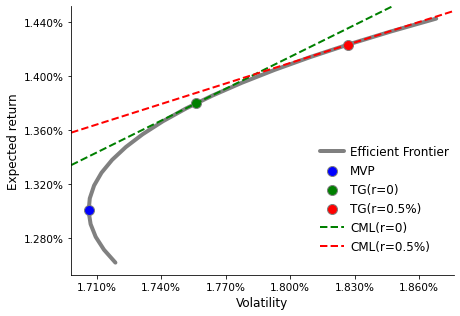

In [84]:
ax = plt.subplots()[1]
ax.plot(b,a, c="grey", zorder=-1, label="Efficient Frontier")
ax.scatter(vols[0], rets[0], marker="o", s=100, fc="b", ec="grey", 
           label="MVP")
ax.scatter(vols[1], rets[1], marker="o", s=100, fc="g", ec="grey", 
           label="TG(r=0)")
ax.scatter(vols[2], rets[2], marker="o", s=100, fc="r", ec="grey", 
           label="TG(r=0.5%)")
ax.set_ylim(*ax.get_ylim())
ax.set_xlim(*ax.get_xlim())
ax.axline((0, 0), (vols[1], rets[1]),  c="g", 
          lw=2, ls="--", label="CML(r=0)")
ax.axline((0, 0.005), (vols[2], rets[2]),  c="r", 
          lw=2, ls="--", label="CML(r=0.5%)")

ax.set_xlabel("Volatility", fontsize=12)
ax.set_ylabel("Expected return", fontsize=12)
ax.legend(loc="best", fontsize=12, framealpha=0)

n_ticks = 6

t = ticker.PercentFormatter(xmax=1)
ax.yaxis.set_major_formatter(t)
ax.xaxis.set_major_formatter(t)
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(n_ticks))
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(n_ticks))
ax.tick_params(axis='both', labelsize=10.5)

ax.legend(loc='best', edgecolor="none", borderaxespad=0., 
              columnspacing=0.3,handletextpad=0.5,markerscale=1.,
              prop=dict(size=12), bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Sharpe Ratio')

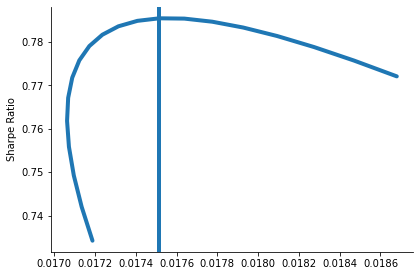

In [69]:
plt.plot(b,a/b)
plt.axvline(b[np.argmax(a/b)])
plt.ylabel("Sharpe Ratio")

## Weights of asset (stacked)